# Make OOF Video
This notebook makes videos of our fold 0 validation predictions compared with ground truth. It puts all 3 video views into 1 video. It also posts statistics and progress line.

**Key:**  
Red - ground truth impact  
White - warns you that ground truth is coming within 10 frames  
Black - warns you that ground truth occurred within 10 frames in past  
  
Blue - model prediction   
Yellow - warns you that prediction is coming within 10 frames  
Green - warns you that prediction occurred within 10 frames in past  

In [1]:
import numpy as np, pandas as pd, os
pd.options.display.max_rows = 999

import cv2
from tqdm.notebook import tqdm
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Video, display

import datetime as dt
from pathlib import Path

In [2]:
train = pd.read_csv('/raid/Kaggle/NFL/train_labels.csv')
print( train.shape )
train.head()

(983885, 14)


,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility
0,57583,82,Endzone,57583_000082_Endzone.mp4,1,H30,629,19,40,24,NaN,NaN,NaN,NaN
1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,NaN,NaN,NaN,NaN
2,57583,82,Endzone,57583_000082_Endzone.mp4,1,V86,871,21,359,17,NaN,NaN,NaN,NaN
3,57583,82,Endzone,57583_000082_Endzone.mp4,1,V74,771,19,345,15,NaN,NaN,NaN,NaN
4,57583,82,Endzone,57583_000082_Endzone.mp4,1,V34,549,26,461,20,NaN,NaN,NaN,NaN


In [3]:
train['target'] = ((train.impact==1)&(train.confidence>1)&(train.visibility>0)).astype('int8')
train['warning'] = 0
train = train.sort_values(['video','label','frame']).reset_index(drop=True)

In [4]:
# MARK PREVIOUS AND FOLLOWING IMPACT SO WE CAN WARN VIEWERS
for k in range(-10,1):
    train.warning += train.target.shift(k).fillna(0)
for k in range(1,11):
    train.warning -= train.target.shift(k).fillna(0)

In [5]:
train['hit'] = train.groupby(['video','frame']).target.transform('max')

# Tracking

In [6]:
track = pd.read_csv('/raid/Kaggle/NFL/train_player_tracking.csv')
track["time"] = pd.to_datetime(track["time"])
track["color"] = track["player"].map(lambda x: "black" if "H" in x else "white")
print( track.shape )
track.head()

(333811, 13)


,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,color
0,57583,82,H97,2018-09-14 00:23:45.500000+00:00,38.89,28.06,0.0,0.0,0.0,261.28,222.79,NaN,black
1,57583,82,H97,2018-09-14 00:23:45.599000+00:00,38.89,28.06,0.0,0.0,0.0,261.28,221.93,NaN,black
2,57583,82,H97,2018-09-14 00:23:45.700000+00:00,38.89,28.06,0.0,0.0,0.0,261.28,221.21,NaN,black
3,57583,82,H97,2018-09-14 00:23:45.799000+00:00,38.88,28.05,0.0,0.0,0.0,261.28,220.07,NaN,black
4,57583,82,H97,2018-09-14 00:23:45.900000+00:00,38.88,28.05,0.0,0.0,0.0,261.28,220.31,NaN,black


In [7]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='forestgreen', zorder=0)  # changed the field color to forestgreen

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

#create_football_field()
#plt.show()

In [8]:
def get_track_image(gameKey=58000, playID=1306, fps=60, frame=10, fmax=300, labels=False, 
                     warn1=[], warn2=[], hit=[]):

    play_track = track.loc[(track.gameKey == gameKey) & (track.playID == playID)]
    snap_time = play_track.loc[play_track.event == 'ball_snap','time'].iloc[0]

    play_start = snap_time - dt.timedelta(seconds = 0.1) #10/fps)
    play_end = play_start + dt.timedelta(seconds = fmax/fps)
    play_track = play_track.loc[(play_track.time>=play_start)&(play_track.time<=play_end)]

    current = play_start + dt.timedelta(seconds = frame/fps)
    abs_timedelta = abs(play_track['time'] - current).dt.total_seconds()
    min_abs_timedelta = abs_timedelta.min()
    play_current = play_track[abs_timedelta == min_abs_timedelta]

    fig, ax = create_football_field(figsize=(20, 12))
    play_current.plot(x="x", y="y",  kind='scatter', ax=ax, color = play_current['color'], s=100)
    
    draw = [warn1,warn2,hit]
    colors = ['white','black','blue']
    widths = [2,2,5]
    
    for i,j in enumerate(draw):
        for k in j:
            row = play_current.loc[(play_current.player==k)]
            if len(row)==0: continue
            row = row.iloc[0]
            ax.plot([row.x-1,row.x-1],[row.y-1,row.y+1],color=colors[i],linewidth=widths[i])
            ax.plot([row.x+1,row.x+1],[row.y-1,row.y+1],color=colors[i],linewidth=widths[i])
            ax.plot([row.x-1,row.x+1],[row.y-1,row.y-1],color=colors[i],linewidth=widths[i])
            ax.plot([row.x-1,row.x+1],[row.y+1,row.y+1],color=colors[i],linewidth=widths[i])

    if labels:
        play_home = play_current.loc[play_current['player'].str.contains('H')]
        play_away = play_current.loc[play_current['player'].str.contains('V')]
        for index, row in play_away.iterrows():
            ax.annotate(row['player'], (row['x'], row['y']), verticalalignment='center', horizontalalignment='right', fontsize=12)
        for index, row in play_home.iterrows():
            ax.annotate(row['player'], (row['x'], row['y']), verticalalignment='center', horizontalalignment='left', 
                    color = 'white', fontsize=12)
    
    #Image from plot
    ax.axis('off')
    fig.tight_layout(pad=0)

    # To remove the huge white borders
    ax.margins(0)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()

    return image_from_plot[72:-72,80:-80,:]

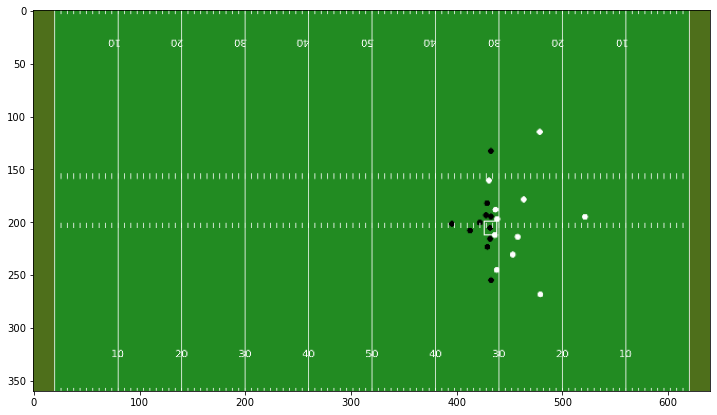

In [9]:
img = get_track_image(57787,3413,frame=50,warn1=['H68'])
plt.figure(figsize=(15,7))
plt.imshow(img[::2,::2,::-1])
plt.show()

In [10]:
img.shape

(720, 1280, 3)

# OOF Predictions

In [11]:
oof = pd.read_csv('../dec-28-20/pred_0_fold_epoch_9_score_001_aug_theo_with_Chris.csv')
valid_videos = oof.video.unique()
print( oof.shape )
oof.head()

(193415, 14)


,Unnamed: 0,gameKey,playID,view,video,frame,left,width,top,height,scores,image_name,pred_cls,pred_chris
0,0,57586,540,Endzone,57586_000540_Endzone.mp4,1,262,22,311,33,0.184864,57586_000540_Endzone_1.png,0.060575,0.046519
1,1,57586,540,Endzone,57586_000540_Endzone.mp4,1,278,26,345,19,0.056537,57586_000540_Endzone_1.png,0.057923,0.046486
2,2,57586,540,Endzone,57586_000540_Endzone.mp4,1,903,21,295,33,0.010745,57586_000540_Endzone_1.png,0.003265,0.046993
3,3,57586,540,Endzone,57586_000540_Endzone.mp4,1,777,22,307,34,0.005583,57586_000540_Endzone_1.png,0.008401,0.049978
4,4,57586,540,Endzone,57586_000540_Endzone.mp4,1,575,19,712,5,0.003924,57586_000540_Endzone_1.png,0.025966,0.047281


In [12]:
# CONFIG FROM OUR LB 0.4117 SUBMISSION

DET_THRESHOLD = 0.5
CLS_THRESHOLD = 0.5

# Adjacency post-processing
NMS_THRESHOLD = 0.35
MAX_FRAME_DIST = 4

# View post-processing
MIN_DIST = 5

# Boxes expansion
R = 0.3

In [13]:
df_pred = oof.loc[oof.scores>DET_THRESHOLD]
print('After detection threshold',df_pred.shape)

After detection threshold (4530, 14)


In [14]:
df_pred = df_pred.loc[df_pred.pred_cls>CLS_THRESHOLD]
print('After classification threshold',df_pred.shape)

After classification threshold (1737, 14)


In [15]:
def Theo_Expand(df_pred_pp,R=0):
    
    df_pred_pp = df_pred_pp.copy()
    if R ==0: return df_pred_pp
    
    # Expansion
    df_pred_pp.left -= df_pred_pp.width * R / 2
    df_pred_pp.top -= df_pred_pp.height * R / 2
    df_pred_pp.width *= 1 + R
    df_pred_pp.height *= 1 + R
    df_pred_pp.left = np.clip(df_pred_pp.left, 0, None)
    df_pred_pp.top = np.clip(df_pred_pp.top, 0, None)
    df_pred_pp.width = np.clip(df_pred_pp.width, 0, 1280 - df_pred_pp.left)
    df_pred_pp.height = np.clip(df_pred_pp.height, 0, 720 - df_pred_pp.top)

    # Rounding 
    right = np.round(df_pred_pp.left + df_pred_pp.width, 0)
    bot = np.round(df_pred_pp.top + df_pred_pp.height, 0)
    df_pred_pp.left = np.round(df_pred_pp.left, 0).astype(int)
    df_pred_pp.top = np.round(df_pred_pp.top, 0).astype(int)

    df_pred_pp.width = (right - df_pred_pp.left).astype(int)
    df_pred_pp.height = (bot - df_pred_pp.top).astype(int)
    
    return df_pred_pp

df_pred = Theo_Expand(df_pred,R)
print('After expand',df_pred.shape)

After expand (1737, 14)


In [16]:
def iou_score(bbox1, bbox2):
    bbox1 = [float(x) for x in bbox1]
    bbox2 = [float(x) for x in bbox2]

    (x0_1, y0_1, x1_1, y1_1) = bbox1
    (x0_2, y0_2, x1_2, y1_2) = bbox2

    # get the overlap rectangle
    overlap_x0 = max(x0_1, x0_2)
    overlap_y0 = max(y0_1, y0_2)
    overlap_x1 = min(x1_1, x1_2)
    overlap_y1 = min(y1_1, y1_2)

    # check if there is an overlap
    if overlap_x1 - overlap_x0 <= 0 or overlap_y1 - overlap_y0 <= 0:
        return 0

    # if yes, calculate the ratio of the overlap to each ROI size and the unified size
    size_1 = (x1_1 - x0_1) * (y1_1 - y0_1)
    size_2 = (x1_2 - x0_2) * (y1_2 - y0_2)
    size_intersection = (overlap_x1 - overlap_x0) * (overlap_y1 - overlap_y0)
    size_union = size_1 + size_2 - size_intersection

    return size_intersection / size_union


def compute_ious(df, max_dist=10):
    ious = np.zeros((len(df), len(df)))
    for i in range(len(df)):
        for j in range(len(df)):
            frames = df["frame"].values[[i, j]]
            if np.abs(frames[0] - frames[1]) > max_dist:
                continue

            try:
                boxes = df[["left", "width", "top", "height"]].values[[i, j]]
            except KeyError:
                boxes = df[["x", "w", "y", "h"]].values[[i, j]]

            boxes[:, 1] += boxes[:, 0]
            boxes[:, 3] += boxes[:, 2]
            boxes = boxes[:, [0, 2, 1, 3]]

            iou = iou_score(boxes[0], boxes[1])
            ious[i, j] = iou
            ious[j, i] = iou
    return ious


def get_centroids(clusts):
    centroids = []
    for clust in clusts:
        if len(clust) == 1:
            centroids.append(clust[0])
        elif (len(clust) % 2) == 1:
            centroids.append(clust[len(clust) // 2 + 1])
        else:
            centroids.append(clust[len(clust) // 2])

    return centroids


def form_clusters(df, threshold=0.5, max_dist=10):
    ious = compute_ious(df, max_dist=max_dist)

    frames = df["frame"]

    clust_mat = np.zeros((len(df), len(df)))

    for i in range(len(df)):
        for j in range(len(df)):
            if frames[i] == frames[j]:
                continue
            elif ious[i, j] > threshold:
                clust_mat[i, j] = 1
                clust_mat[j, i] = 1

    clusts = [[0]]
    for i in range(1, len(df)):
        in_clust = False
        for clust in clusts[::-1]:
            if clust_mat[clust[-1], i]:
                in_clust = True
                clust.append(i)
                break

        if not in_clust:
            clusts.append([i])

    centroids = get_centroids(clusts)

    return clusts, centroids


def post_process_adjacency(df, threshold=0.5, max_dist=10, min_clust_size=0):
    dfs_pp = []
    for video in tqdm(df["video"].unique()):
        df_video = df[df["video"] == video].reset_index(drop=True).copy()
        clusts, centroids = form_clusters(
            df_video, threshold=threshold, max_dist=max_dist
        )
        centroids = [
            centroids[i]
            for i in range(len(centroids))
            if len(clusts[i]) >= min_clust_size
        ]

        df_video_pp = (
            df_video.iloc[centroids].sort_values("frame").reset_index(drop=True)
        )
        dfs_pp.append(df_video_pp)

    df_pp = pd.concat(dfs_pp).reset_index(drop=True)
    return df_pp

df_pred = post_process_adjacency(
    df_pred,
    threshold=NMS_THRESHOLD,
    max_dist=MAX_FRAME_DIST,
)
print('After adjacency PP',df_pred.shape)


After adjacency PP (377, 14)


In [17]:
def post_process_view(df, min_dist=4):
    to_drop = []
    for keys in tqdm(df.groupby(["gameKey", "playID"]).size().to_dict().keys()):

        tmp_df = df.query("gameKey == @keys[0] and playID == @keys[1]")
        tmp_to_drop = []
        for index, row in tmp_df.iterrows():
            if row["view"] == "Endzone":
                other_view = tmp_df.query('view == "Sideline"')
            else:
                other_view = tmp_df.query('view == "Endzone"')

            distances = other_view["frame"].apply(lambda x: np.abs(x - row["frame"]))
            if np.min(distances) > min_dist:
                tmp_to_drop.append(index)

        if len(tmp_to_drop) != len(tmp_df):
            to_drop += tmp_to_drop

    return df.drop(index=to_drop).reset_index(drop=True)

df_pred = post_process_view(df_pred, min_dist=MIN_DIST)
print('After view PP',df_pred.shape)


After view PP (222, 14)


In [18]:
from scipy.optimize import linear_sum_assignment

def iou_ltwh(bbox1, bbox2):
    
    
    bbox1 = [float(x) for x in bbox1]
    bbox2 = [float(x) for x in bbox2]
    
    bbox1[2] += bbox1[0] 
    bbox1[3] += bbox1[1] 
    
    bbox2[2] += bbox2[0] 
    bbox2[3] += bbox2[1] 

    (x0_1, y0_1, x1_1, y1_1) = bbox1
    (x0_2, y0_2, x1_2, y1_2) = bbox2

    # get the overlap rectangle
    overlap_x0 = max(x0_1, x0_2)
    overlap_y0 = max(y0_1, y0_2)
    overlap_x1 = min(x1_1, x1_2)
    overlap_y1 = min(y1_1, y1_2)

    # check if there is an overlap
    if overlap_x1 - overlap_x0 <= 0 or overlap_y1 - overlap_y0 <= 0:
            return 0

    # if yes, calculate the ratio of the overlap to each ROI size and the unified size
    size_1 = (x1_1 - x0_1) * (y1_1 - y0_1)
    size_2 = (x1_2 - x0_2) * (y1_2 - y0_2)
    size_intersection = (overlap_x1 - overlap_x0) * (overlap_y1 - overlap_y0)
    size_union = size_1 + size_2 - size_intersection

    return size_intersection / size_union

def precision_calc(gt_boxes, pred_boxes):
    cost_matix = np.ones((len(gt_boxes), len(pred_boxes)))
    for i, box1 in enumerate(gt_boxes):
        for j, box2 in enumerate(pred_boxes):
            dist = abs(box1[0]-box2[0])
            if dist > 4:
                continue
            iou_score2 = iou_ltwh(box1[1:], box2[1:])

            if iou_score2 < 0.35:
                continue
            else:
                cost_matix[i,j]=0

    row_ind, col_ind = linear_sum_assignment(cost_matix)
    fn = len(gt_boxes) - row_ind.shape[0]
    fp = len(pred_boxes) - col_ind.shape[0]
    tp=0
    for i, j in zip(row_ind, col_ind):
        if cost_matix[i,j]==0:
            tp+=1
        else:
            fp+=1
            fn+=1
    return tp, fp, fn

def competition_metric(valid_labels, pred_df, output=False):
    ftp, ffp, ffn = [], [], []
    cols = ['frame', 'left', 'top', 'width', 'height']
    for video in valid_labels['video'].unique():
        pred_boxes = pred_df[pred_df['video'] == video][cols].values
        gt_boxes = valid_labels[valid_labels['video'] == video][cols].values
       
        tp, fp, fn = precision_calc(gt_boxes, pred_boxes)
        ftp.append(tp)
        ffp.append(fp)
        ffn.append(fn)
    
    tp = np.sum(ftp)
    fp = np.sum(ffp)
    fn = np.sum(ffn)
    precision = tp / (tp + fp + 1e-6)
    recall =  tp / (tp + fn +1e-6)
    f1_score = 2*(precision*recall)/(precision+recall+1e-6)
    if output:
        return tp, fp, fn, precision, recall, f1_score
    else:
        print(f'TP: {tp}, FP: {fp}, FN: {fn}, PRECISION: {precision:.4f}, RECALL: {recall:.4f}, F1 SCORE: {f1_score}')

true = train.loc[(train.video.isin(valid_videos))&(train.impact==1)&(train.confidence>1)&(train.visibility>0)]
print('ground truth shape', true.shape )
competition_metric(true, df_pred)

ground truth shape (368, 17)
TP: 139, FP: 83, FN: 229, PRECISION: 0.6261, RECALL: 0.3777, F1 SCORE: 0.4711859696988299


# Make Videos

In [19]:
print( df_pred.shape )
df_pred.head()

(222, 14)


,Unnamed: 0,gameKey,playID,view,video,frame,left,width,top,height,scores,image_name,pred_cls,pred_chris
0,528,57586,540,Endzone,57586_000540_Endzone.mp4,55,786,33,303,29,0.988241,57586_000540_Endzone_55.png,0.867275,0.245381
1,540,57586,540,Endzone,57586_000540_Endzone.mp4,56,812,27,300,36,0.861564,57586_000540_Endzone_56.png,0.808124,0.186502
2,558,57586,540,Endzone,57586_000540_Endzone.mp4,57,549,28,293,35,0.517537,57586_000540_Endzone_57.png,0.828908,0.330238
3,557,57586,540,Endzone,57586_000540_Endzone.mp4,57,324,32,301,26,0.518536,57586_000540_Endzone_57.png,0.509017,0.043638
4,589,57586,540,Endzone,57586_000540_Endzone.mp4,60,774,33,300,42,0.863600,57586_000540_Endzone_60.png,0.588504,0.333078


In [20]:
# Modified function from to take single frame.
# https://www.kaggle.com/samhuddleston/nfl-1st-and-future-getting-started
def annotate_frame(gameKey, playID, video_labels, slow=1, stop_frame=-1, start_frame=-1) -> str:
    VIDEO_CODEC = "MP4V"
    BLACK = (0, 0, 0)    # Black
    WHITE = (255, 255, 255)    # White
    IMPACT_COLOR = (0, 0, 255)  # Red
    PRED_COLOR = (255, 0, 0) # Blue
    PRED_COLOR_WARN1 = (0, 255, 255) # Yellow
    PRED_COLOR_WARN2 = (0, 255, 0) # Green
    
    tp, fp, fn, pp, rr, ff = competition_metric(true.loc[(true.gameKey==gameKey)&(true.playID==playID)],
                               df_pred.loc[(df_pred.gameKey==gameKey)&(df_pred.playID==playID)],True)
    
    video_path1 = '/raid/Kaggle/NFL/train/%i_%.6i_Endzone.mp4'%(gameKey,playID)
    video_path2 = '/raid/Kaggle/NFL/train/%i_%.6i_Sideline.mp4'%(gameKey,playID)
    
    video_name1 = os.path.basename(video_path1)
    video_name2 = os.path.basename(video_path2)
    
    hits1 = train.loc[train.video==video_name1].drop_duplicates('frame').sort_values('frame').hit.values
    f_max1 = train.loc[train.video==video_name1,'frame'].max()
    hits2 = train.loc[train.video==video_name2].drop_duplicates('frame').sort_values('frame').hit.values
    f_max2 = train.loc[train.video==video_name2,'frame'].max()
    
    hits3 = df_pred.loc[df_pred.video==video_name1].frame.unique()
    hits4 = df_pred.loc[df_pred.video==video_name2].frame.unique()
    
    if f_max1 != f_max2:
        print('## WARNING: different length videos')
    f_max = min(f_max1,f_max2)
    print('Converting',f_max,'frames...',end='')
    
    vidcap1 = cv2.VideoCapture(video_path1)
    vidcap2 = cv2.VideoCapture(video_path2)
    
    fps = vidcap1.get(cv2.CAP_PROP_FPS)
    width1 = int(vidcap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height1 = int(vidcap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    output_path = "labeled_" + video_name1.replace('_Endzone','')
    tmp_output_path = "tmp_" + output_path
    output_video = cv2.VideoWriter(tmp_output_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps/slow, (width1, height1))
    
    frame = 0
    while True:
        
        print(frame,', ',end='')
        img = np.zeros((height1,width1,3),dtype='uint8')
                
        it_worked1, img1 = vidcap1.read()
        if not it_worked1: break
            
        it_worked2, img2 = vidcap2.read()
        if not it_worked2: break
            
        if frame<start_frame: 
            frame += 1
            continue
        if frame==stop_frame: break
            
        img[360:,:640,:] = img1[::2,::2,:]
        img[360:,640:,:] = img2[::2,::2,:]
        
        # We need to add 1 to the frame count to match the label frame index that starts at 1
        frame += 1
        
        # Let's add a frame index to the video so we can track where we are
        img_name = f"GamePlay_{video_name1.replace('_Endzone.mp4','')}_frame{frame}"
        cv2.putText(img, img_name, (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, WHITE, thickness=2)
        
        metric = f'TP: {tp}, FP: {fp}, FN: {fn}, PRECISION: {pp:.3f}, RECALL: {rr:.3f}, F1 SCORE: {ff:.4f}'
        cv2.putText(img, metric, (10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, thickness=1)
            
        # MAKE FOUR PROGRESS LINES
        hh = 100
        cv2.line(img, (20,hh),(600,hh),(0,0,255),4)
        for k in np.where( hits1==1 )[0]:
            x = int(k/f_max * 580 + 20)
            cv2.rectangle(img, (x-1,hh-10),(x+1,hh+10),(0,0,255),cv2.FILLED) 
        x = int(frame/f_max * 580 + 20)
        cv2.rectangle(img, (x-1,hh-10),(x+1,hh+10),(255,255,255),cv2.FILLED) 
        
        hh = 150
        cv2.line(img, (20,hh),(600,hh),(0,0,255),4)
        for k in np.where( hits2==1 )[0]:
            x = int(k/f_max * 580 + 20)
            cv2.rectangle(img, (x-1,hh-10),(x+1,hh+10),(0,0,255),cv2.FILLED) 
        x = int(frame/f_max * 580 + 20)
        cv2.rectangle(img, (x-1,hh-10),(x+1,hh+10),(255,255,255),cv2.FILLED) 
        
        hh = 200
        cv2.line(img, (20,hh),(600,hh),(255,0,0),4)
        for k in hits3:
            x = int(k/f_max * 580 + 20)
            cv2.rectangle(img, (x-1,hh-10),(x+1,hh+10),(255,0,0),cv2.FILLED) 
        x = int(frame/f_max * 580 + 20)
        cv2.rectangle(img, (x-1,hh-10),(x+1,hh+10),(255,255,255),cv2.FILLED) 
        
        hh = 250
        cv2.line(img, (20,hh),(600,hh),(255,0,0),4)
        for k in hits4:
            x = int(k/f_max * 580 + 20)
            cv2.rectangle(img, (x-1,hh-10),(x+1,hh+10),(255,0,0),cv2.FILLED) 
        x = int(frame/f_max * 580 + 20)
        cv2.rectangle(img, (x-1,hh-10),(x+1,hh+10),(255,255,255),cv2.FILLED) 
        
        w1, w2, h1 = [], [], []
        
        # DRAW 4 SETS OF BOXES
        boxes = video_labels.query("video == @video_name1 and frame == @frame and warning != 0")
        for box in boxes.itertuples(index=False):
            left = box.left//2
            top = box.top//2 + 360
            width = box.width//2
            height = box.height//2
            if box.impact == 1 and box.confidence > 1 and box.visibility > 0:   
                color, thickness = IMPACT_COLOR, 2
                print('(Impact frame',frame,box.label,box.confidence,box.visibility,')',end='')  
                h1.append(box.label)
            elif box.warning == 1:    
                color, thickness = WHITE, 1
                w1.append(box.label)
            else:
                color, thickness = BLACK, 1
                w2.append(box.label)
            # Add a box around the helmet
            cv2.rectangle(img, (left, top), (left + width, top + height), color, thickness=thickness)
            #cv2.putText(img, box.label, (left, max(0, top - 5//2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, thickness=1)
            
        # Now, add the boxes
        boxes = video_labels.query("video == @video_name2 and frame == @frame and warning != 0")
        for box in boxes.itertuples(index=False):
            left = box.left//2 + 640
            top = box.top//2 + 360
            width = box.width//2
            height = box.height//2
            if box.impact == 1 and box.confidence > 1 and box.visibility > 0:   
                color, thickness = IMPACT_COLOR, 2
                #print('Impact frame',frame,box.label,box.confidence,box.visibility)            
            elif box.warning == 1:    
                color, thickness = WHITE, 1
            else:
                color, thickness = BLACK, 1
            # Add a box around the helmet
            cv2.rectangle(img, (left, top), (left + width, top + height), color, thickness=thickness)
            #cv2.putText(img, box.label, (left, max(0, top - 5//2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, thickness=1)
            
            
        #Now, add the boxes
        boxes = df_pred.loc[(df_pred.video == video_name1) & (abs(df_pred.frame - frame)<=10)]
        for box in boxes.itertuples(index=False):
            left = box.left//2
            top = box.top//2 + 360
            width = box.width//2
            height = box.height//2
            if box.frame == frame:   
                color, thickness = PRED_COLOR, 2
                print('(Pred frame',frame,')',end='')  
            elif box.frame > frame:
                color, thickness = PRED_COLOR_WARN1, 1
            else:
                color, thickness = PRED_COLOR_WARN2, 1
                
            # Add a box around the helmet
            cv2.rectangle(img, (left, top), (left + width, top + height), color, thickness=thickness)
            #cv2.putText(img, box.label, (left, max(0, top - 5//2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, thickness=1)
                              
        #Now, add the boxes
        boxes = df_pred.loc[(df_pred.video == video_name2) & (abs(df_pred.frame - frame)<=10)]
        for box in boxes.itertuples(index=False):
            left = box.left//2 + 640
            top = box.top//2 + 360
            width = box.width//2
            height = box.height//2
            if box.frame == frame:   
                color, thickness = PRED_COLOR, 2
                #print('(Pred frame',frame,')',end='') 
            elif box.frame > frame:
                color, thickness = PRED_COLOR_WARN1, 1
            else:
                color, thickness = PRED_COLOR_WARN2, 1

            # Add a box around the helmet
            cv2.rectangle(img, (left, top), (left + width, top + height), color, thickness=thickness)
            #cv2.putText(img, box.label, (left, max(0, top - 5//2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, thickness=1)
            
        # DRAW ARIAL VIEW WITH TRACKING INFO
        img3 = get_track_image(gameKey,playID,fps,frame+1,f_max, warn1=w1, warn2=w2, hit=h1)
        img[:360,640:,:] = img3[::2,::2,:]    
        
        
        output_video.write(img)
    output_video.release()
    
    # Not all browsers support the codec, we will re-load the file at tmp_output_path and convert to a codec that is more broadly readable using ffmpeg
    if os.path.exists(output_path):
        os.remove(output_path)
    subprocess.run(["ffmpeg", "-i", tmp_output_path, "-crf", "18", "-preset", "veryfast", "-vcodec", "libx264", output_path])
    os.remove(tmp_output_path)
    
    return output_path

In [21]:
# THESE ARE JIN'S PAIRS 0 THRU 11
valid_games = ['57586_000540','57586_001934','57586_004152','58106_002918','57778_004244','57781_000252',
               '57783_003374','57784_001741','57910_001164','58000_001306','58098_001193','58107_004362']

In [22]:
pair = 2
game = valid_games[pair]
g = int( game.split('_')[0] )
p = int( game.split('_')[1] )
annotate_frame(g, p, video_labels=train, slow=15, start_frame = -1, stop_frame = -1 )

Converting 515 frames...0 , 1 , 

'labeled_57586_004152.mp4'

In [23]:
display(Video(data='labeled_%i_%.6i.mp4'%(g,p), embed=True))

This is a sample of the video. You can delete this markdown cell

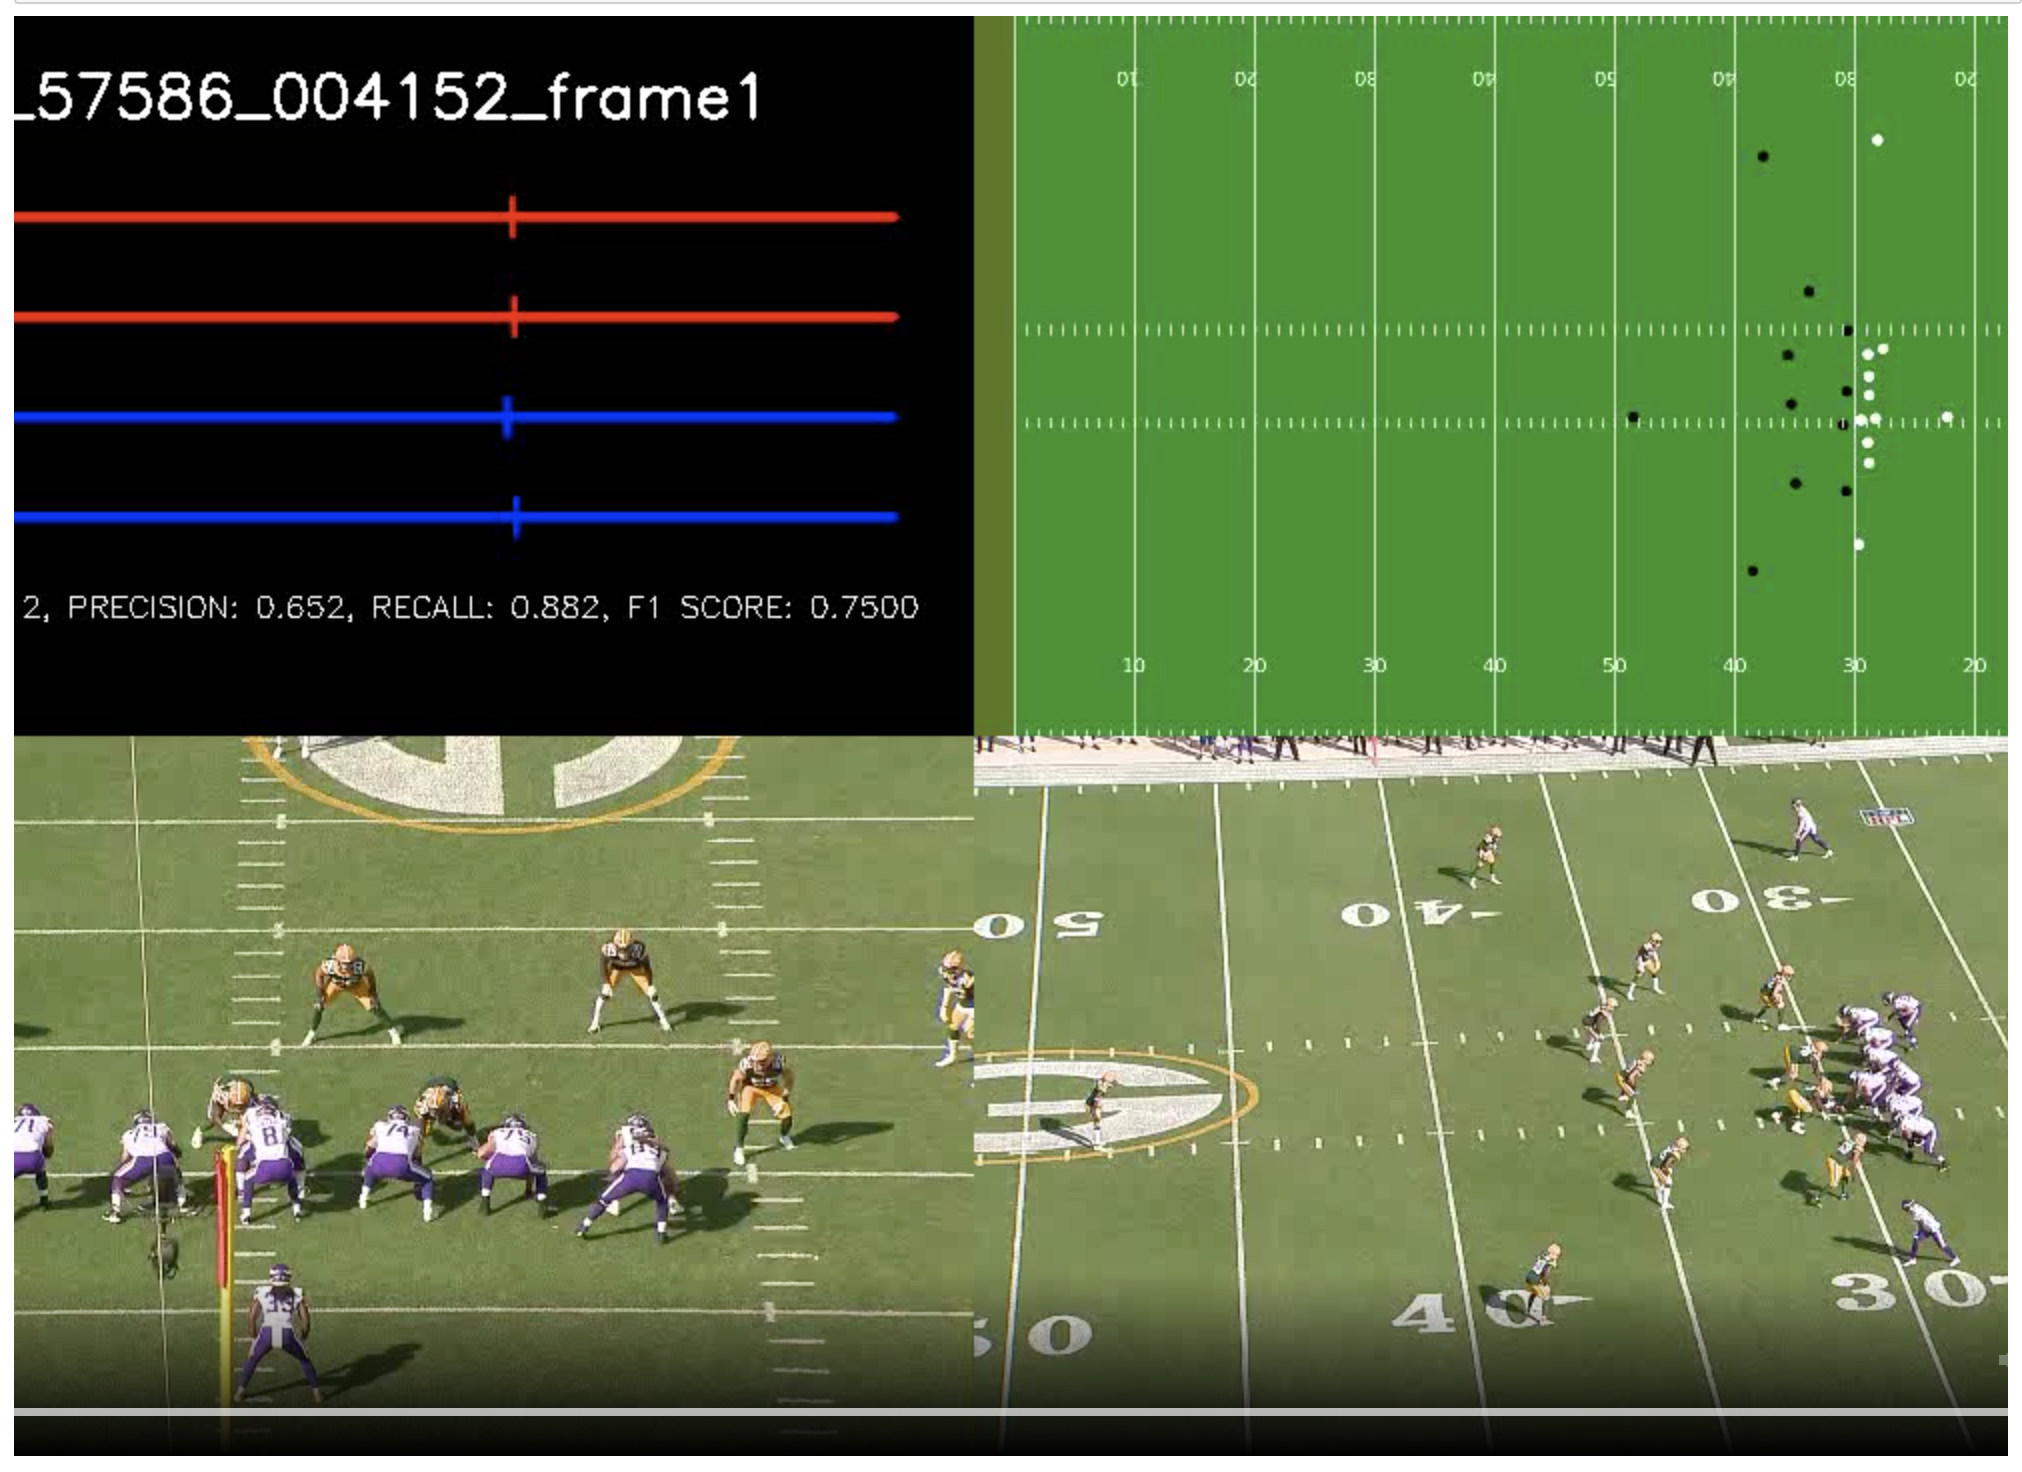